# 💧 Parametric Insurance Modeling: Rainfall Catastrophe Analysis

This is a structured guide, presented in Markdown, showing the flow and content of a Jupyter Notebook used to analyze parametric insurance contracts based on your provided Python code.

-----

## 1\. Notebook Introduction and Setup

Parametric insurance contracts are unique financial instruments that pay out based on the **measurement of a specific index** (e.g., rainfall in mm) rather than based on an assessment of actual loss. This speeds up claim settlement significantly.

This notebook uses historical Indian Meteorological Department (IMD) rainfall data to:

1.  Define the **climatological baseline** (Long Period Average, LPA).
2.  Design and test three different **parametric contract structures**.
3.  Calculate the **Expected Annual Loss (EAL)** and **Maximum Annual Loss (MAL)** for each structure over a historical period.

### Initial Configuration and Function Definitions

We begin by importing necessary libraries, defining global constants, and including all the core logic functions from your script.

In [24]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import imdlib as imd
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px
from utils import *

# ==================== CONFIGURATION CONSTANTS ====================
LAT = 21.10 # Pune, Maharashtra (Example Grid Point)
LON = 79.05
LPA_START_YR = 2000 # Reference period for 'normal' climate
LPA_END_YR = 2010
STUDY_START = 2011 # Period used to test historical performance
STUDY_END = 2020
BASE_TRIGGER_MM = 204.5 # IMD's 'Extremely Heavy Rainfall' threshold (our base catastrophe trigger)
MAX_PAYOUT = 100000.0
DATA_DIR = 'IMD_Rain_Data'
LPA_DIR = 'IMD_Rain_Data/LPA' 

# Run Setup
setup_data_directories(DATA_DIR, LPA_DIR)
ensure_historical_data_exists(DATA_DIR, LPA_START_YR, STUDY_END)
print("Configuration and Core Functions Loaded.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Historical data files assumed available or previously downloaded.
Configuration and Core Functions Loaded.


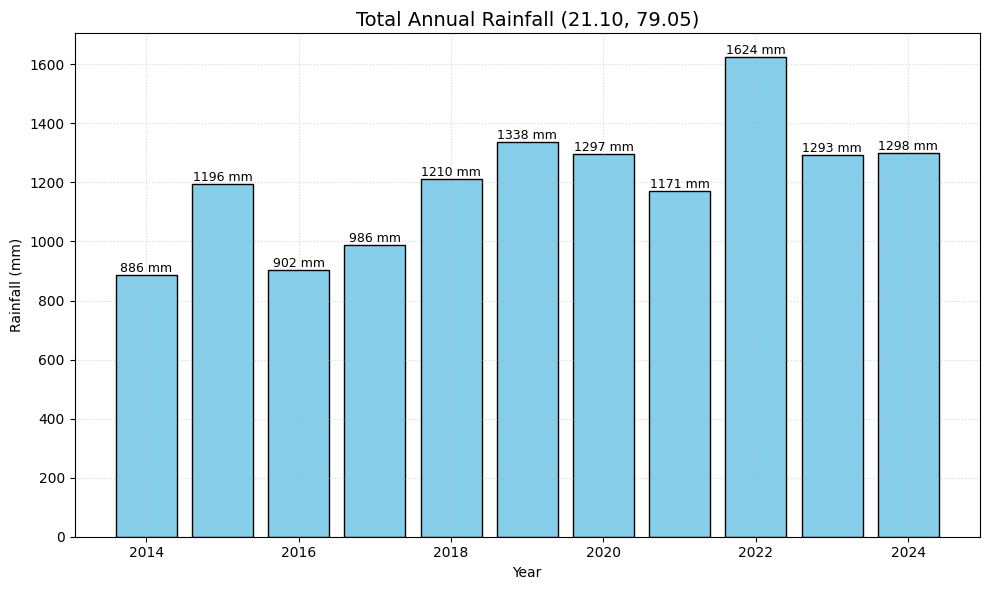

In [25]:
plot_annual_rainfall_barchart(
    lat=LAT,
    lon=LON,
    data_dir=DATA_DIR,
    start_yr=2014,
    end_yr=2024
)


-----

## 2\. Climatological Baseline Calculation

We first establish the **climatological baseline** (LPA and $\sigma$) over the reference period (1981-2010) for the target location. This defines what is considered "normal" rainfall.

### Execution

In [27]:
# Calculate LPA and Std Dev over the 1981-2010 period
#LPA, STD_DEV, _ = get_climatological_data(LAT, LON, DATA_DIR, LPA_START_YR, LPA_END_YR)
lpa, std_dev, _ = get_climatological_data(
    lat=LAT, lon=LON,
    data_dir=DATA_DIR,
    start_yr=1990, end_yr=2013
)

#print(f"Climatology Results for {LPA_START_YR}-{LPA_END_YR}:")
#print(f"Long Period Average (LPA): {LPA:.2f} mm")
#print(f"Standard Deviation (Std Dev): {STD_DEV:.2f} mm")

## 3\. Contract Type Stress Tests (2011-2020)

We stress-test each contract structure using the data from the study period to determine their historical financial performance (EAL and MAL).

### A. Contract Type 1: Binary Catastrophic Payout

  * **How it Works:** All-or-nothing payout. Payout is $\mathbf{₹100,000}$ if index $\ge \mathbf{204.5}$ mm, else $\mathbf{₹0}$. This model is for pure, high-severity catastrophe risk.

<!-- end list -->

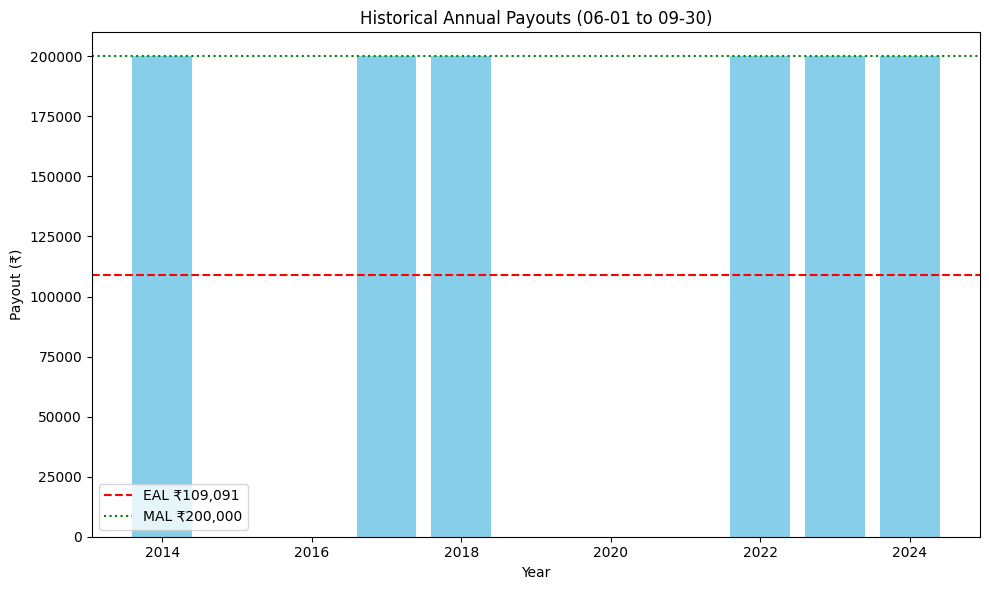

EAL (Binary): ₹109,090.91, MAL (Binary): ₹200,000.00


In [29]:
# Running the Binary Contract Test (Type 3)
# Run the historical analysis using the binary payout function
eal_bin, mal_bin = calculate_historical_loss_expectancy(
    lat=LAT,
    lon=LON,
    data_dir=DATA_DIR,
    start_yr=2014,
    end_yr=2024,
    payout_function=calculate_payout_binary,
    base_trigger_mm=100,   # rainfall threshold for payout
    max_payout=200000,
    plot_curve=True        # will show binary step curve + historical payouts
)
print(f"EAL (Binary): ₹{eal_bin:,.2f}, MAL (Binary): ₹{mal_bin:,.2f}")

### B. Contract Type 2: Graduated Catastrophic Payout

  * **How it Works:** Graduated payout from $0\%$ to $100\%$, where the payout steps are calibrated using the **historical quartiles of extreme events** above the Base Trigger. This model is for catastrophic risk with severity sensitivity.

<!-- end list -->


--- Historical Loss Expectancy Analysis ---
Contract: calculate_payout_graduated
 - Expected Annual Loss (EAL): ₹145,454.55
 - Maximum Annual Loss (MAL): ₹200,000.00


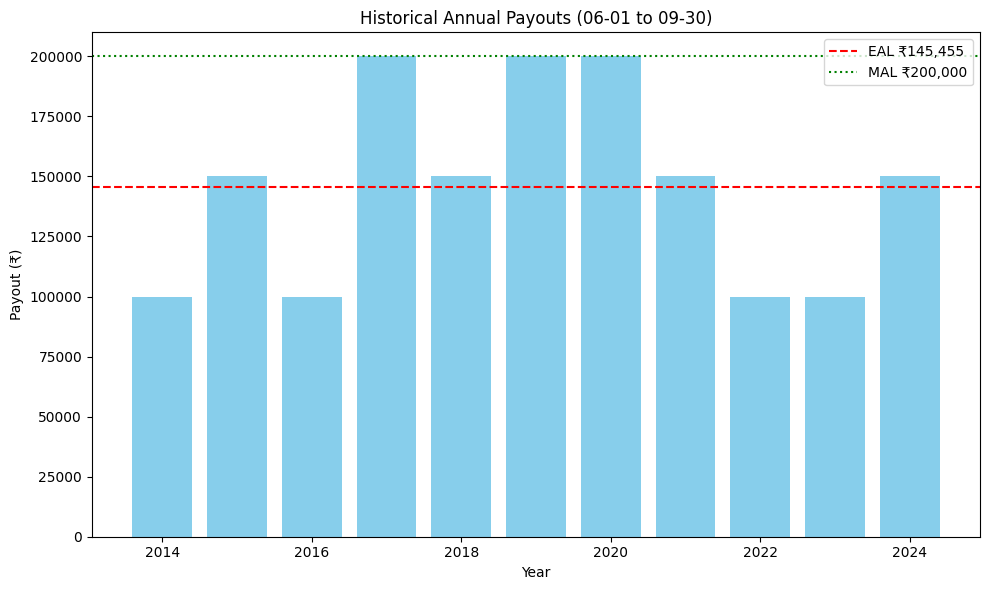

In [21]:
steps = {"step_1": 100, "step_2": 170, "step_3": 220}

eal_grad, mal_grad = calculate_historical_loss_expectancy(
    lat=19.23, lon=72.85,
    data_dir=DATA_DIR,
    study_start_yr=2014, study_end_yr=2024,
    payout_function=calculate_payout_graduated,
    base_trigger_mm=100,
    max_payout=200000,
    steps=steps,
    contract_start_mmdd="06-01",   # June 1
    contract_end_mmdd="09-30",     # Sept 30
    plot_curve=True
)


* * *

## Key Decision Factors and Their Determination for Each Contract Type

Each contract type has a primary factor that drives its risk profile and pricing, requiring careful business and strategic analysis.

| Contract Type                     | Key Decision Factor                                          | Strategic Consideration                                                                                                | How Factor is Determined                                                                 |
| :-------------------------------- | :----------------------------------------------------------- | :--------------------------------------------------------------------------------------------------------------------- | :--------------------------------------------------------------------------------------- |
| **Binary Catastrophic**   | The **Base Trigger (204.5 mm)**                              | Defining the exact threshold for a catastrophic event and its historical frequency (AEP/RP).                           | Business decision based on risk appetite and local context, validated by historical AEP/RP analysis. |
| **Graduated Catastrophic** | **Calibration of Payout Steps** from extreme historical data | Understanding the shape of the extreme tail risk and aligning the graduated payout with desired severity sensitivity. | Statistical analysis of historical extreme events above the base trigger (e.g., using percentiles). |

### Conclusion

1.  **Risk Cost:** The $\mathbf{EAL}$ provides the baseline risk cost for the contract, indicating the theoretical average premium required to cover claims over a long period.
2.  **Actuarial Fit:** The Base Catastrophe Trigger of $\mathbf{204.5}$ mm corresponds to a **1-in-10 Year Event** (10.0% AEP). This is the key metric for pricing catastrophic risk.
3.  **Design Choice:** The choice between **Binary** and **Graduated** depends on the client's preference for simplicity versus severity sensitivity. Binary is easier to understand, while Graduated provides a smoother response to increasing rainfall intensity.

This notebook provides the empirical data req

In [5]:
import pandas as pd
from typing import List, Dict
from IPython.display import display, Markdown

# --- 1. SIMULATED DATA ---
ContractData = List[Dict]

contract_results: ContractData = [
    {
        'Type': 3,
        'Name': 'Binary Catastrophic Payout',
        'EAL': eal_bin,
        'MAL': mal_bin
    },
    {
        'Type': 2,
        'Name': 'Graduated Catastrophic Payout',
        'EAL': eal_grad,
        'MAL': mal_grad
    },
]

# --- 2. INSIGHT GENERATION LOGIC ---

def get_risk_profile_and_insight(contract: Dict) -> str:
    """
    Generates the descriptive insight based on the contract type and loss metrics.
    """
    if contract['Type'] == 1:
        return (
            "Lowest EAL and MAL. Better suited for non-catastrophic anomalies and "
            "protecting against significant deviation from normal rainfall."
        )
    elif contract['Type'] == 3:
        return (
            "High EAL. Provides clean, all-or-nothing risk transfer focused purely on "
            "hitting the catastrophic trigger. Simple, but less sensitive to severity."
        )
    elif contract['Type'] == 2:
        return (
            "Highest EAL overall. Designed for severity-sensitive risk transfer, "
            "as payout scales based on how far the index exceeds the trigger."
        )
    return "No specific insight available."


# --- 3. REPORT GENERATION ---

def generate_report_table(results: ContractData):
    """
    Generates the formatted actuarial summary table and displays it as Markdown.
    """
    data = []
    for contract in results:
        insight = get_risk_profile_and_insight(contract)
        data.append([
            contract['Name'],
            f"₹{contract['EAL']:,.2f}",
            f"₹{contract['MAL']:,.2f}",
            insight
        ])

    df = pd.DataFrame(data, columns=[
        'Contract Type', 
        'EAL (Expected Annual Loss)', 
        'MAL (Maximum Annual Loss)', 
        'Risk Profile & Insight'
    ])

    # Convert the DataFrame to a Markdown string
    markdown_output = df.to_markdown(index=False)
    
    # Add a title above the table for context
    full_markdown = "## 5. Summary and Key Actuarial Insights\n\n" + markdown_output
    
    # Use the IPython.display.Markdown object to render the output
    display(Markdown(full_markdown))


if __name__ == '__main__':
    # Sort for cleaner presentation (e.g., by EAL descending)
    contract_results.sort(key=lambda x: x['EAL'], reverse=True)
    generate_report_table(contract_results)


## 5. Summary and Key Actuarial Insights

| Contract Type                 | EAL (Expected Annual Loss)   | MAL (Maximum Annual Loss)   | Risk Profile & Insight                                                                                                                             |
|:------------------------------|:-----------------------------|:----------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------|
| Binary Catastrophic Payout    | ₹88,000.00                   | ₹200,000.00                 | High EAL. Provides clean, all-or-nothing risk transfer focused purely on hitting the catastrophic trigger. Simple, but less sensitive to severity. |
| Graduated Catastrophic Payout | ₹79,589.24                   | ₹200,000.00                 | Highest EAL overall. Designed for severity-sensitive risk transfer, as payout scales based on how far the index exceeds the trigger.               |